In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_undirected
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt

In [42]:
#loading the data 
df = pd.read_csv(r"/home/aryan/sop_fd/neeww(1).csv")

In [43]:
#using a subset of the data for prototyping
sample_size = int(len(df)*.2)
sampled_indices = random.sample(range(len(df)), sample_size)
df = df.iloc[sampled_indices].reset_index(drop=True)

In [44]:
# Create the Graph and Add Nodes
G = nx.Graph()
num_users = len(df)
G.add_nodes_from(range(num_users))

In [45]:

# Cosine Similarity Edge Formation
feature_matrix = df.values
for i in range(num_users):
    for j in range(i + 1, num_users):
        vec1 = feature_matrix[i, 0:8]  # Assuming columns 1-3 are features
        vec2 = feature_matrix[j, 0:8]
        similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        if similarity >= 0.5:
            G.add_edge(i, j)

In [46]:

# K-hop Graph Construction
def khop_graph(G, k):
    khop_G = nx.Graph()
    for node in G.nodes:
        neighbors = nx.single_source_shortest_path_length(G, node, cutoff=k)
        for neighbor, dist in neighbors.items():
            if dist <= k:
                khop_G.add_edge(node, neighbor)
    return khop_G

In [47]:


k = 3
G_khop = khop_graph(G, k)
print(f"K-hop graph created with {len(G_khop.nodes)} nodes and {len(G_khop.edges)} edges.")


K-hop graph created with 500 nodes and 125250 edges.


In [48]:
### 3️⃣ Compute Normalized Laplacian ###
A = nx.to_numpy_array(G_khop)
D = np.diag(A.sum(axis=1))
L = D - A  # Unnormalized Laplacian
D_inv_sqrt = np.linalg.inv(np.sqrt(D))
L_norm = np.eye(A.shape[0]) - np.matmul(D_inv_sqrt, A).dot(D_inv_sqrt)

# Convert to PyTorch Tensor
laplacian_tensor = torch.tensor(L_norm, dtype=torch.float)

In [49]:
# Centrality Calculation on K-hop Graph
centralities = {
    'degree': nx.degree_centrality(G_khop),
    'betweenness': nx.betweenness_centrality(G_khop),
    'closeness': nx.closeness_centrality(G_khop),
    'eigenvector': nx.eigenvector_centrality(G_khop, max_iter=1000)
}

print("Centrality calculation completed.")

Centrality calculation completed.


In [15]:
import pickle
filename = 'a.pkl'
with open(filename, 'wb') as file:
    pickle.dump(centralities, file)  # 'wb' for write binary

In [8]:
import pickle
filename = 'a.pkl'
with open(filename, 'rb') as file:
    centralities = pickle.load(file)  # 'rb' for read binary

In [50]:
# Feature matrix with centralities (excluding user ID)
X = np.array([[centralities['degree'][i],
               centralities['betweenness'][i],
               centralities['closeness'][i],
               centralities['eigenvector'][i]]
              for i in range(num_users)])

In [51]:
# SIR Simulation on K-hop Graph
def sir_simulation(G, patient_zero, beta=0.3, gamma=0.1, max_iter=50):
    states = {n: 'S' for n in G.nodes()}
    states[patient_zero] = 'I'
    infected_count = [1]

    for _ in range(max_iter):
        new_infections, recoveries = 0, 0

        for node in list(G.nodes()):
            if states[node] == 'I':
                for neighbor in G.neighbors(node):
                    if states[neighbor] == 'S' and np.random.random() < beta:
                        states[neighbor] = 'I'
                        new_infections += 1

                if np.random.random() < gamma:
                    states[node] = 'R'
                    recoveries += 1

        infected_count.append(infected_count[-1] + new_infections - recoveries)

        if infected_count[-1] == 0:
            break

    return max(infected_count)

In [52]:
sir_labels = np.zeros(num_users)
for i in range(num_users):
    sir_labels[i] = sir_simulation(G_khop, i)
print("SIR simulation completed.")

threshold = np.percentile(sir_labels, 80)
y = (sir_labels >= threshold).astype(int)

SIR simulation completed.


In [ ]:
filename = 'b.pkl'
with open(filename, 'wb') as file:
    pickle.dump(y, file)  # 'wb' for write binary

In [12]:

filename = 'b.pkl'
with open(filename, 'rb') as file:
    y = pickle.load(file)  

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [ ]:
print(np.array_equal(y, d))  


In [54]:

# Convert Graph to PyG Edge Index
edge_index = torch.tensor(list(G_khop.edges())).t().contiguous()

# Features and Labels
features = torch.tensor(X, dtype=torch.float32)
labels = torch.tensor(y, dtype=torch.long)


In [55]:
# GCN Model with corrected initialization
class TrustGCN(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=8):
        super(TrustGCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)
        
    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))
        
        # Fully connected processing
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

Epoch 0, Loss: 0.6723
Epoch 10, Loss: 0.5407
Epoch 20, Loss: 0.5301
Epoch 30, Loss: 0.5173
Epoch 40, Loss: 0.4781
Epoch 50, Loss: 0.4345
Epoch 60, Loss: 0.4141
Epoch 70, Loss: 0.4008
Epoch 80, Loss: 0.3870
Epoch 90, Loss: 0.7011
Epoch 100, Loss: 0.4368
Epoch 110, Loss: 0.4071
Epoch 120, Loss: 0.3607
Epoch 130, Loss: 0.3389
Epoch 140, Loss: 0.3504
Epoch 150, Loss: 0.3751
Epoch 160, Loss: 0.5691
Epoch 170, Loss: 0.4971
Epoch 180, Loss: 0.4190
Epoch 190, Loss: 0.3519


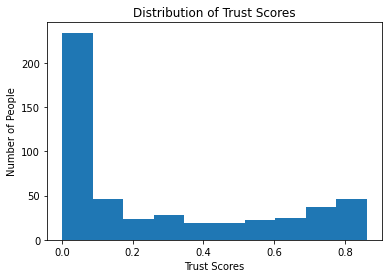

User 0: Insufficient trust score
User 1: Insufficient trust score
User 2: Insufficient trust score
User 3: Insufficient trust score
User 4: Insufficient trust score
User 5: Insufficient trust score
User 6: Insufficient trust score
User 7: Insufficient trust score
User 8: Insufficient trust score
User 9: Insufficient trust score
User 10: Insufficient trust score
User 11: Insufficient trust score
User 12: Insufficient trust score
User 13: Insufficient trust score
User 14: Insufficient trust score
User 15: Insufficient trust score
User 16: Insufficient trust score
User 17: Insufficient trust score
User 18: Insufficient trust score
User 19: Insufficient trust score
User 20: Insufficient trust score
User 21: Insufficient trust score
User 22: Insufficient trust score
User 23: Insufficient trust score
User 24: Insufficient trust score
User 25: Insufficient trust score
User 26: Insufficient trust score
User 27: Insufficient trust score
User 28: Insufficient trust score
User 29: Insufficient tr

In [56]:
edge_index = torch.tensor(list(G.edges())).t().contiguous()
features = torch.tensor(X, dtype=torch.float32)
labels = torch.tensor(y, dtype=torch.long)

# 5️⃣ Training with SIR-based Loss
model = TrustGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()

    output = model(features, edge_index)
    loss = F.nll_loss(output, labels)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# 6️⃣ Trust Evaluation and Access Control
with torch.no_grad():
    model.eval()
    log_probs = model(features,edge_index)
    influence_scores = torch.exp(log_probs[:, 1])

trust_scores = influence_scores.numpy()

num, bins = np.histogram(trust_scores, bins=10)
bin_width = bins[1] - bins[0]
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.bar(bin_centers, num, width=bin_width, align='center')
plt.xlabel("Trust Scores")
plt.ylabel("Number of People")
plt.title("Distribution of Trust Scores")
plt.show()

trust_threshold = 0.7
connection_fading = 0.5

def grant_access(user_id):
    department = df.iloc[user_id][4:8].idxmax().split('_')[1]
    trust = trust_scores[user_id]

    if trust < trust_threshold:
        return False, "Insufficient trust score"

    if department == '3':
        return True, "Full access granted"
    else:
        return True, "Standard access granted"

for user_id in df.index:
    access, message = grant_access(user_id)
    print(f"User {user_id}: {message}")

def apply_fading_factor(G, pl, di):
    rho = (1 - pl + di) / 2
    for u, v in G.edges():
        G[u][v]['weight'] *= rho
    return G

In [40]:
features.type()

'torch.FloatTensor'

In [60]:
features = features.numpy()

In [61]:
features.shape

(500, 4)

In [62]:
### 7️⃣ Apply SHAP for Explainability ###
def model_predict(X):
    X_tensor = torch.tensor(X, dtype=torch.float)
    return model(X_tensor, edge_index).detach().numpy()

explainer = shap.Explainer(model_predict, features)
shap_values = explainer(features)
shap.summary_plot(shap_values, features)

RuntimeError: index 100 is out of bounds for dimension 0 with size 100

In [19]:
user_ids_to_explain = list(range(5))

In [ ]:
print(features.shape)

In [ ]:
numpy_array = features.cpu().numpy()

    # Create a Pandas DataFrame from the NumPy array
dataframe = pd.DataFrame(numpy_array)

In [20]:
# Add these imports at the top of your file
import shap
import lime
import lime.lime_tabular
from sklearn.ensemble import RandomForestClassifier





In [ ]:

num_samples = 50 #Reduced to 50 for this example.
selected_features = features[:num_samples]
mask = (edge_index[0] < num_samples) & (edge_index[1] < num_samples)
selected_edge_index = edge_index[:, mask]

#Debugging code.
print(f"Max edge index value: {torch.max(selected_edge_index)}")
print(f"Number of nodes: {selected_features.shape[0]}")

class TrustGCNWrapper(nn.Module):
    def __init__(self, model, edge_index):
        super(TrustGCNWrapper, self).__init__()
        self.model = model
        self.edge_index = edge_index

    def forward(self, x):
        return self.model(x, self.edge_index)

wrapped_model = TrustGCNWrapper(model, selected_edge_index)

explainer = shap.GradientExplainer(wrapped_model, selected_features)
shap_values = explainer.shap_values(selected_features)

print(shap_values.shape)

In [ ]:
shap.dependence_plot(centralities, shap_values[0], features)

In [ ]:
explain_with_shap(model, features, edge_index, user_ids_to_explain)

In [21]:
import shap
import lime
import lime.lime_tabular
from sklearn.ensemble import RandomForestClassifier

# After your model training, add these explainability functions:
print(features)
def explain_with_shap(model, features, edge_index, user_ids_to_explain):
    """
    Use SHAP to explain model decisions for specific users
    """
    # Create a wrapper function that returns probabilities for both classes
    def model_wrapper(x):
        if len(x.shape) == 1:
            x = x.reshape(1, -1)
        x_tensor = torch.tensor(x, dtype=torch.float32)
        with torch.no_grad():
            out = model(x_tensor, edge_index)
        return torch.exp(out).numpy()  # Convert log-probs to probabilities
    background = features.numpy()  # Use the actual feature matrix
    # Initialize SHAP explainer with background samples
      # Use 10 background samples
    explainer = shap.KernelExplainer(
        model_wrapper,
        background,
        link="logit"
    )
    
    explanations = {}
    for user_id in user_ids_to_explain:
        try:
            # Get SHAP values for this user
            user_features = features[user_id].numpy().reshape(1, -1)
            shap_values = explainer.shap_values(
                    user_features,
                    nsamples=100
                )
            
            # For binary classification, SHAP returns values for both classes
            if isinstance(shap_values, list):
                # Use values for the positive class (trusted)
                shap_values = shap_values[1]
            
            # Store explanation
            explanations[user_id] = {
                'features': ['degree', 'betweenness', 'closeness', 'eigenvector'],
                'shap_values': shap_values[0],  # Get first (and only) sample
                'base_value': explainer.expected_value[1],
                'trust_score': trust_scores[user_id],
                'access_granted': trust_scores[user_id] >= trust_threshold
            }
            
            # Plot the explanation
            shap.force_plot(
                explainer.expected_value[1],
                shap_values[0],
                user_features[0],  # Use the flattened features
                feature_names=['degree', 'betweenness', 'closeness', 'eigenvector'],
                matplotlib=True,
                show=False
            )
            plt.title(f"SHAP explanation for User {user_id}")
            plt.show()
            
        except Exception as e:
            print(f"Failed to explain user {user_id}: {str(e)}")
            continue
    
    return explanations

tensor([[1.0040, 0.0000, 1.0000, 0.0447],
        [1.0040, 0.0000, 1.0000, 0.0447],
        [1.0040, 0.0000, 1.0000, 0.0447],
        ...,
        [1.0040, 0.0000, 1.0000, 0.0447],
        [1.0040, 0.0000, 1.0000, 0.0447],
        [1.0040, 0.0000, 1.0000, 0.0447]])


In [19]:
explain_with_shap(model, features, edge_index, user_ids_to_explain)

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Exception ignored in: <function tqdm.__del__ at 0x783877d57910>
Traceback (most recent call last):
  File "/home/aryan/.local/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/aryan/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/home/aryan/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 150, in display
    d = self.format_dict
  File "/home/aryan/.local/lib/python3.10/site-packages/tqdm/std.py", line 1462, in format_dict
    'colour': self.colour}
  File "/home/aryan/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 195, in colour
    return self.container.children[-2].style.bar_color
AttributeError: 'FloatProgress' object has no attribute 'style'


Failed to explain user 0: 'FloatProgress' object has no attribute 'style'


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Failed to explain user 1: 'FloatProgress' object has no attribute 'style'


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Failed to explain user 2: 'FloatProgress' object has no attribute 'style'


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Exception ignored in: <function tqdm.__del__ at 0x783877d57910>
Traceback (most recent call last):
  File "/home/aryan/.local/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/aryan/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/home/aryan/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 150, in display
    d = self.format_dict
  File "/home/aryan/.local/lib/python3.10/site-packages/tqdm/std.py", line 1462, in format_dict
    'colour': self.colour}
  File "/home/aryan/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 195, in colour
    return self.container.children[-2].style.bar_color
AttributeError: 'FloatProgress' object has no attribute 'style'
Exception ignored in: <function tqdm.__del__ at 0x783877d57910>
Traceback (most recent call last):
  File "/home/aryan/.local/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __de

Failed to explain user 3: 'FloatProgress' object has no attribute 'style'


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Failed to explain user 4: 'FloatProgress' object has no attribute 'style'


{}

In [1]:
print(5)

5
